In [1]:
# plot PC1 of ratings vs type frequency for real data
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# file paths
base_file = '/share/garg/311_data/sb2377/clean_codebase/three_year_base.csv'
results_dir = '/share/garg/311_data/sb2377/results'
full_data_file = '/share/garg/311_data/sb2377/clean_codebase/full.h5'

# user specified arguments
job_id = 3000
epoch = '59'

# plotting parameters
figsize=(3, 3)
save_path = "/home/sb2377/gnn_crowdsourced_model/figures/type_rating_frequency.pdf"

In [3]:
# load files
base_df = pd.read_csv(base_file)
full_df = pd.read_hdf(full_data_file, 'df')

In [4]:
# get the principal components of the predicted ratings 
# get ratings
with open('{}/job{}/epoch={}_test.pkl'.format(results_dir, job_id, epoch), 'rb') as file:
    _, _, _, node_embedding, type_embedding, _, _, _, _, _ = pickle.load(file)
pred_ratings = torch.Tensor(np.dot(node_embedding, type_embedding.T).T)

# center the data
mean = torch.mean(pred_ratings, dim=0)
centered_ratings = pred_ratings - mean

# compute the covariance matrix
cov_matrix = torch.mm(centered_ratings.T, centered_ratings) / (centered_ratings.size(0) - 1)

# compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)

# sort the eigenvalues and eigenvectors
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, sorted_indices]

# project the data onto the PCs
projected_ratings = torch.mm(centered_ratings, eigenvectors)

In [7]:
# get the type frequencies
mean_reports = full_df.groupby('type_idxs')['finegrained_reported'].mean()
type_freqs = list(mean_reports.to_dict().values())

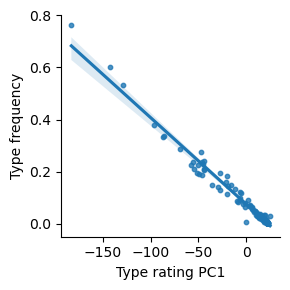

In [8]:
# create figure
plt.figure(figsize=figsize)
# create the scatter plot with a line of best fit
sns.regplot(x=projected_ratings[:, 0].numpy(), y=type_freqs, scatter_kws={'s':10})

# label the axes
plt.xlabel("Type rating PC1")
plt.ylabel("Type frequency")

sns.despine()

plt.tight_layout()
# plt.savefig(save_path, format="pdf", bbox_inches="tight")